In [2]:
import os
import sys
from pathlib import Path

ASL = os.path.join(str(Path.home()), "ASL")
src = os.path.join(str(Path.home()), "ASL", "src")
os.chdir( ASL )
sys.path.append(ASL)
sys.path.append(src)


from lightning import Network
from utils_asl import load_yaml
from visu import Visualizer

vi = Visualizer(p_visu="test")

textwidth = 12.7 #cm


import matplotlib
import matplotlib.pyplot as plt
import skimage
from PIL import Image, ImageDraw
import imageio 
import numpy as np
import torch
import cv2
import pandas
from visu import *

val_res_paths = ["/home/jonfrey/Results/semi_4_scenes/2021-07-28T21:02:55_cl_005_unltimited_mem_ratio05"]
#val_res_paths = ["/home/jonfrey/Results/semi_4_scenes/2021-07-28T02:07:06_cl_09"]

b = "/home/jonfrey/Documents/master_thesis/Report/images/learning_curves_matrixes/"
titels = ["Semi-Supervised 4 Tasks"]

for i in range( len(titels)):
    print( titels[i], val_res_paths[i].split('/')[-2:] )
outnames= [b + s.split("/")[-1]+"acc" for s in val_res_paths]
val_res_paths = [s+"/val_res.pkl" for s in val_res_paths]


for titel, val_res_path, outname in zip(titels,val_res_paths, outnames):
    print(titel)
    run_matrix("", val_res_path,outname)


Semi-Supervised 4 Tasks ['semi_4_scenes', '2021-07-28T21:02:55_cl_005_unltimited_mem_ratio05']
Semi-Supervised 4 Tasks


NameError: name 'run_matrix' is not defined

In [1]:
import numpy as np 
import pickle
from visu import MainVisualizer
from matplotlib import cm
from PIL import Image
from visu.visualizer import get_img_from_fig
from visu.colors import *
    
def run_lr(titel, val_res_path,outname):

    main_visu = MainVisualizer(p_visu="test",store=False)

    with open(val_res_path, "rb") as input_file:
        res = pickle.load(input_file)
    res[-2] = list(range(len(res[-2])))

    task_nr = len(res) - 2
    names = [f"val_acc_{idx}" for idx in range(task_nr)]

    task_nrs, task_indices = np.unique(np.array(res[-1]), return_index=True)

    count = (task_indices + 1).tolist()
    count = count + [res[-2][-1]]
    x = np.array(res[-2])
    y = [np.array(res[i]) for i in range(task_nr)]

    
    def plot_lines_with_background(
        x,
        y,
        count=None,
        x_label="x",
        y_label="y",
        title="Title",
        task_names=None,
        **kwargs,
      ):
        fig, ax = plt.subplots(figsize=(6,4))
        left  = 0.13  # the left side of the subplots of the figure
        right = 0.96    # the right side of the subplots of the figure
        bottom = 0.15   # the bottom of the subplots of the figure
        top = 0.9  # the top of the subplots of the figure
        wspace = 0.0   # the amount of width reserved for blank space between subplots
        hspace = 0  # the amount of height reserved for white space between subplots

        plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


        plt.xlabel(x_label,fontsize=16, fontname= 'Liberation Serif')
        plt.ylabel(y_label,fontsize=16, fontname= 'Liberation Serif')
        plt.title(title, fontname= 'Liberation Serif', fontsize= 20)
        plt.grid(True)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)

        if type(y) is not list:
          y = [y]

        keys = list(COL_DICT.keys())
        for j, y_ in enumerate(y):
          if type(x) is list:
            if len(x) == len(y):
              x_ = x[j]
            else:
              x_ = x[0]
          else:
            x_ = x
          if x_.shape[0] == 1:
            x_ = x_.repeat(2, 0)
            y_ = y_.repeat(2, 0)

          ax.plot(x_, y_, color=np.array(COL_DICT[keys[j]]) / 255)
        if task_names is not None:
          plt.legend(task_names)

        length = x.max() - x.min()

        nr_tasks = len(y)
        if count is None:
          for i in range(0, nr_tasks):
            print("Plotting")
            print((i) * length / nr_tasks)
            plt.axvspan(
              (i) * length / nr_tasks,
              (i + 1) * length / nr_tasks,
              facecolor=np.array(COL_DICT[keys[i]]) / 255,
              alpha=0.2,
            )
        else:
          start = x.min()
          for i in range(0, len(count)):

            stop = count[i]
            plt.axvspan(
              max(start, x.min()),
              min(stop, x.max()),
              facecolor=np.array(COL_DICT[keys[i]]) / 255,
              alpha=0.2,
            )
            start = stop

        arr = get_img_from_fig(fig, dpi=300)
        plt.close()
        return np.uint8(arr)
    print( (task_indices - 1).tolist()[1:] + [len(res[-1])] )
    arr = plot_lines_with_background(
        x,
        y,
        count= [1]+(task_indices - 1).tolist()[2:] + [len(res[-1])],
        x_label="Epoch",
        y_label="Acc",
        title=titel,
        task_names=["Pre-train","Room Test 1","Room Test 2"," Room Test 3","Room Test 4"],
        tag="Validation_Accuracy_Summary",
        jupyter=True
    )
    
    Image.fromarray( arr )

    print(outname)
    imageio.imwrite( f"{outname}_learning_curve.png", arr)
run_lr(titel, val_res_path,outname)

ModuleNotFoundError: No module named 'visu'

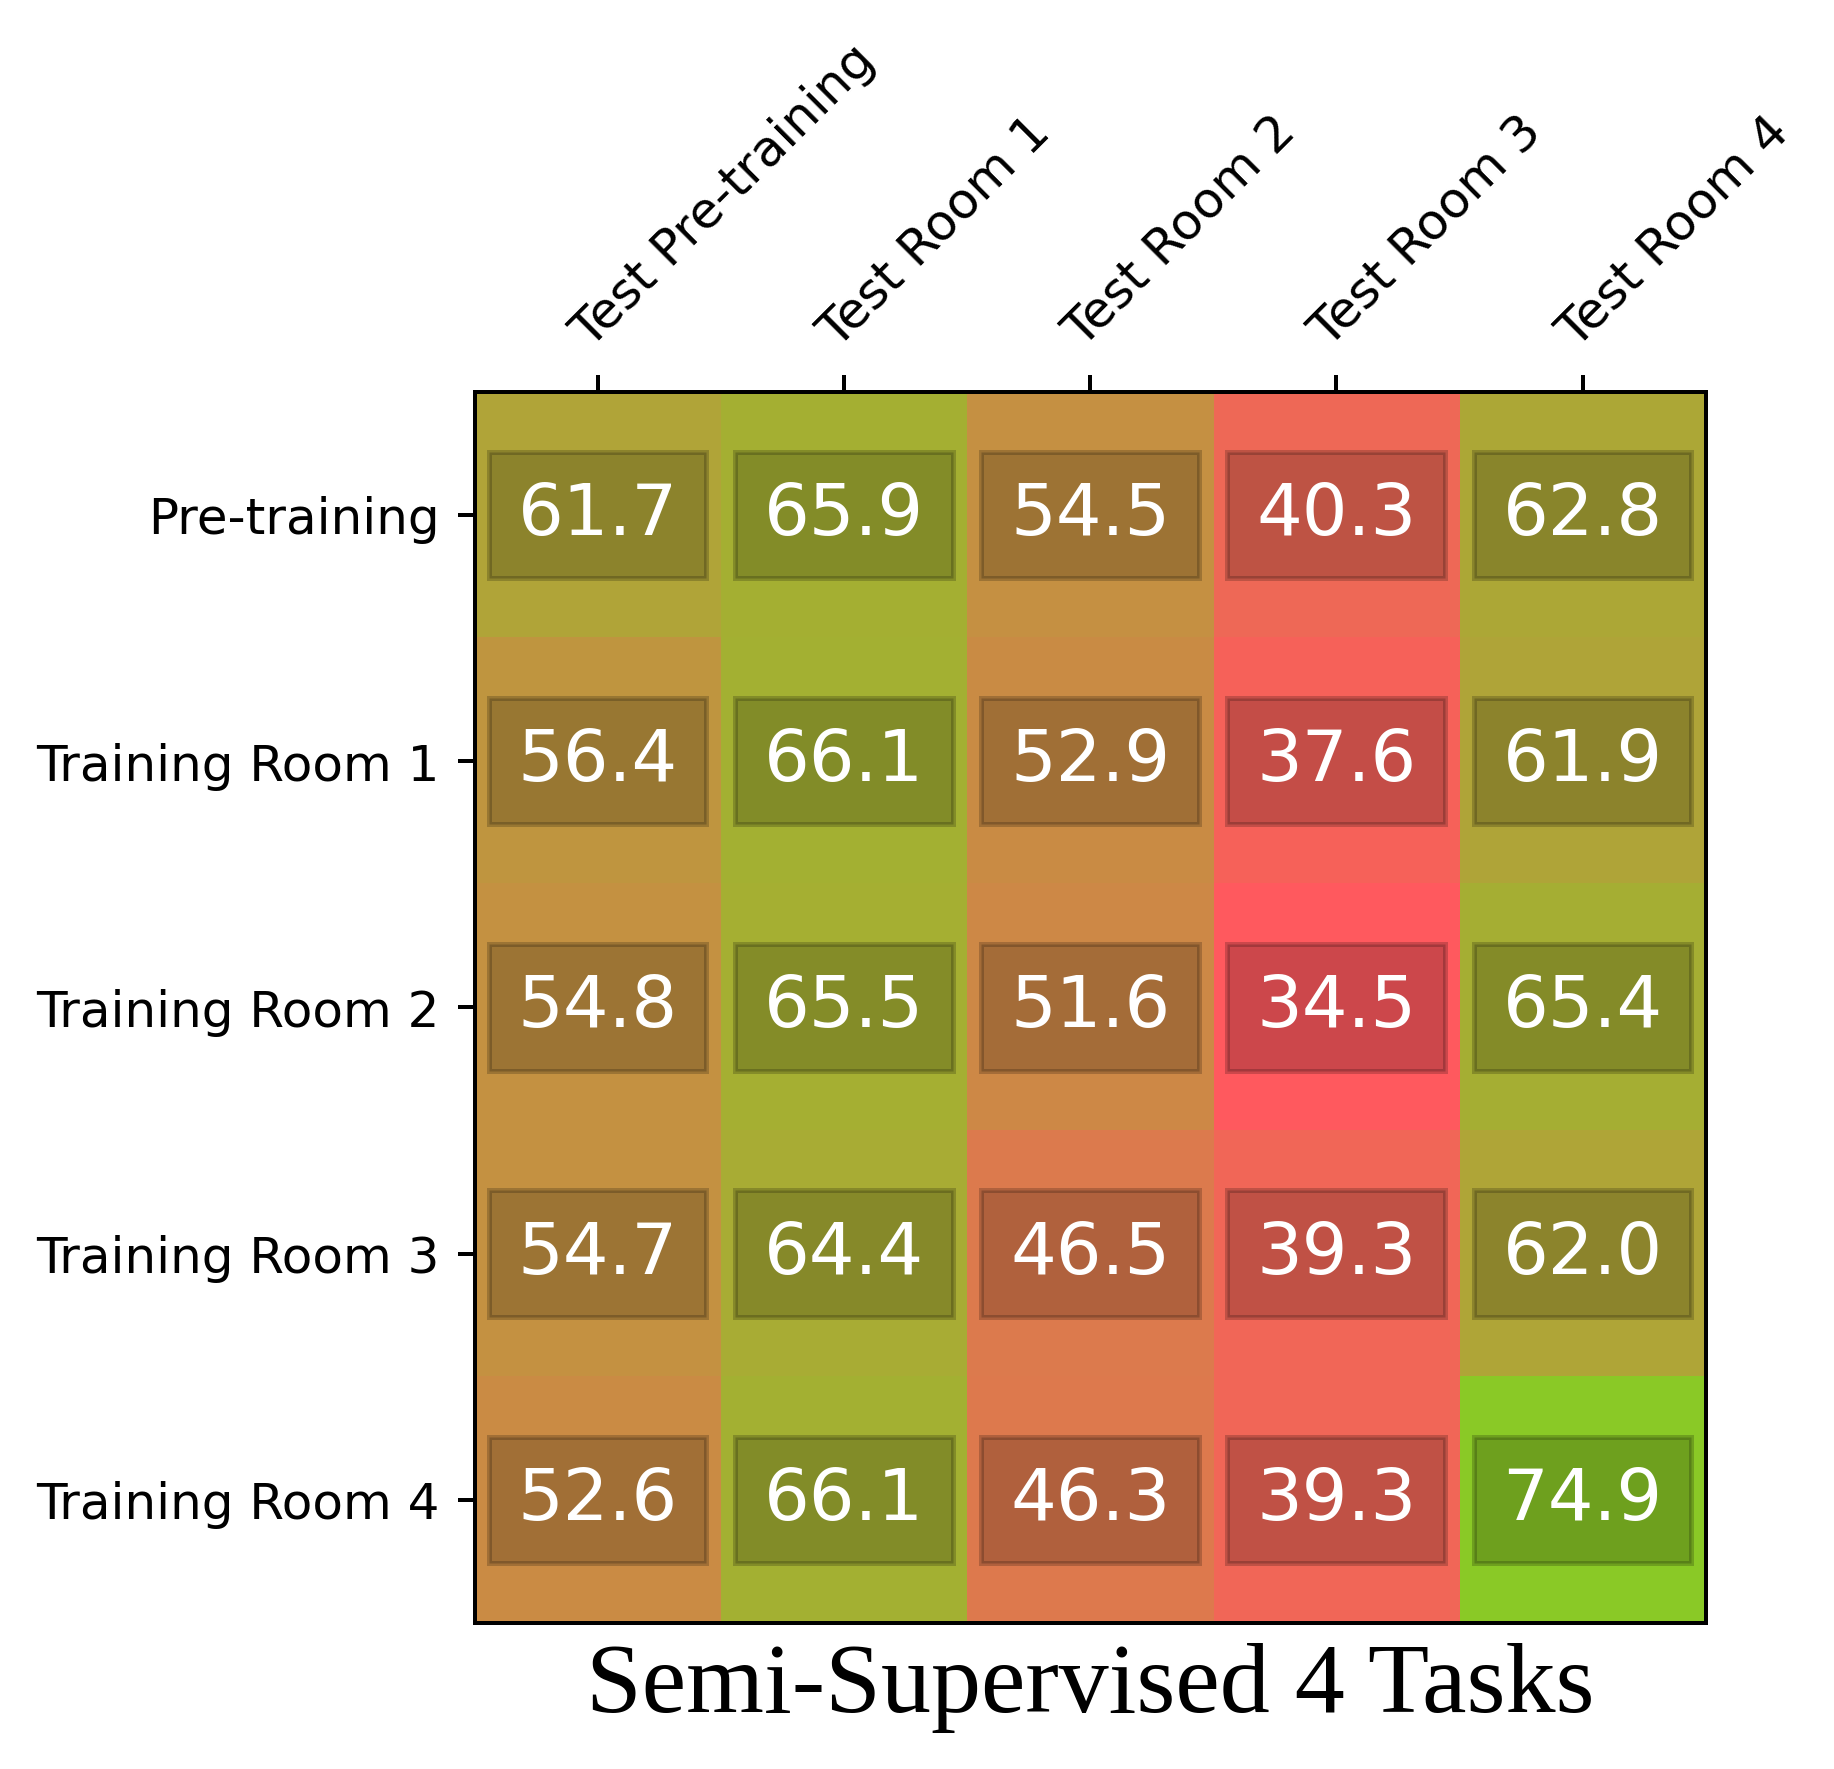

In [7]:
def mat_from_pkl(a):
    with open(a, "rb") as input_file:
        data = pickle.load(input_file)
    res= np.unique( np.array( data[-1] ), return_index =True) 
    idx = res[1]
    mat = np.zeros( (idx.shape[0], idx.shape[0]))
    data = [np.array(d) for d in data]

    el = data[-1].max()+1
    for i in range( el ):
        for j in range( el  ):
            mat[i,j] = data[j][data[-1] == i][-1]
    return mat


def plot_matrix(
        data_matrix,
        higher_is_better=True,
        title="TitleNotDefined",
        max_tasks=None,
        max_tests=None,
        label_x=None,
        label_y=None,
        color_map="custom",
        col_map=None,
        **kwargs,
    ):
        if max_tasks is None and max_tests is None:
          max_tasks = data_matrix.shape[0]
          max_tests = data_matrix.shape[1]
        else:
          d1 = data_matrix.shape[0]
          d2 = data_matrix.shape[1]
          assert d2 <= max_tests
          data = np.zeros((max_tasks, max_tests))
          if max_tasks > d1:

            data[:d1, :d2] = data_matrix
          else:
            data[:max_tasks, :d2] = data_matrix[:max_tasks, :d2]

          data_matrix = data

        if label_y is None:
          label_y = ["Task  " + str(i) for i in range(max_tasks)]
        if label_x is None:
          label_x = ["Test " + str(i) for i in range(max_tests)]

        fig, ax = plt.subplots( figsize=(4.5,4.5),dpi=600 )
        if col_map != None:
          im = ax.imshow(data_matrix, cmap=col_map)
        else:
          if higher_is_better:
            if color_map == "custom":
              im = ax.imshow(data_matrix, cmap=RG_PASTEL)
            else:
              im = ax.imshow(data_matrix, cmap=cm.get_cmap("PiYG"))
          else:
            if color_map == "custom":
              im = ax.imshow(data_matrix, cmap=RG_PASTEL_r)
            else:
              im = ax.imshow(data_matrix, cmap=cm.get_cmap("PiYG_r"))

        # We want to show all ticks...
        ax.set_xticks(np.arange(len(label_x)))
        ax.set_yticks(np.arange(len(label_y)))
        # ... and label them with the respective list entries
        ax.set_xticklabels(label_x)
        ax.set_yticklabels(label_y)

        # Rotate the tick labels and set their alignment.

        # ax.invert_xaxis()
        ax.xaxis.tick_top()
        plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
        # Loop over data dimensions and create text annotations.
        for i in range(len(label_x)):
          for j in range(len(label_y)):
            text = ax.text(
              i,
              j,
              data_matrix[j, i],
              ha="center",
              va="center",
              color="w",
              fontdict={"backgroundcolor": (0, 0, 0, 0.2)},
                fontsize="x-large"
            )

        #ax.set_title(title)
        ax.set_xlabel( title, fontsize=20, fontname= 'Liberation Serif')
        from visu.visualizer import get_img_from_fig
        left  = 0.01  # the left side of the subplots of the figure
        right = 1.1# the right side of the subplots of the figure
        bottom = 0.1   # the bottom of the subplots of the figure
        top = 0.86   # the top of the subplots of the figure
        wspace = 0.0   # the amount of width reserved for blank space between subplots
        hspace = 0.2  # the amount of height reserved for white space between subplots

        plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

        res = get_img_from_fig(fig, dpi=360)
        return res

def run_matrix(titel, val_res_path,outname):
    mat = mat_from_pkl(val_res_path)

    mat = np.round( mat* 100,1 )

    res = plot_matrix(
        mat[:,:],
        title = titel,
    label_y = ["Pre-training", "Training Room 1", "Training Room 2", "Training Room 3", "Training Room 4"],
    label_x = ["Test Pre-training", "Test Room 1", "Test Room 2", "Test Room 3", "Test Room 4"])
    imageio.imwrite( f"{outname}_matrix.png", res)
    
run_matrix(titel, val_res_path,outname)